# Выбор локации для скважины

Задача: на основании данных нефтеразведки необходимо провести анализ и принять решение о выборе места разработки новой скважины.

Данные для анализа -  пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Требуется Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Анализ возможной прибыли и рисков проводится техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений; количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import matplotlib.pyplot as plt #импоpт необходимых библиотек и методов
import numpy as np
import pandas as pd 
import pandas_profiling
import seaborn as sns
import warnings

from numpy.random import RandomState
from pandas_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline

In [3]:
warnings.simplefilter('ignore')#отключение предупреждений

### Загрузка данных геологоразведки для исследуемых регионов

In [4]:
data_0 = pd.read_csv(r'C:\Users\lebeda\Yandex_Practicum\Yandex_projects\data_sets\prjkt_8(sp11)\geo_data_0.csv') #чтение файла данных геологоразведки региона 0

In [5]:
data_1 = pd.read_csv(r'C:\Users\lebeda\Yandex_Practicum\Yandex_projects\data_sets\prjkt_8(sp11)\geo_data_1.csv') #чтение файла данных геологоразведки региона 1

In [6]:
data_2 = pd.read_csv(r'C:\Users\lebeda\Yandex_Practicum\Yandex_projects\data_sets\prjkt_8(sp11)\geo_data_2.csv') #чтение файла данных геологоразведки региона 2

In [7]:
data_list = [data_0, data_1, data_2]

### Ознакомление с данными

In [8]:
n = 0
for i in data_list: #пример содержания загружкнных таблиц
    print('Region', n, ':')
    print(i.head())
    print()
    n+=1
    

Region 0 :
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

Region 1 :
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

Region 2 :
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746



**Ознакомление с данными по региону 0** 

In [9]:
pandas_profiling.ProfileReport(data_0) #получение отчета разведочного анализа данных для региона 0

Number of variables,5
Number of observations,100000
Total Missing (%),0.0%
Total size in memory,3.8 MiB
Average record size in memory,40.0 B
Numeric,4
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


**Ознакомление с данными по региону 1** 

In [10]:
pandas_profiling.ProfileReport(data_1) #получение отчета разведочного анализа данных для региона 1

Number of variables,5
Number of observations,100000
Total Missing (%),0.0%
Total size in memory,3.8 MiB
Average record size in memory,40.0 B
Numeric,3
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,1


**Ознакомление с данными по региону 2** 

In [11]:
pandas_profiling.ProfileReport(data_2) #получение отчета разведочного анализа данных для региона 2

Number of variables,5
Number of observations,100000
Total Missing (%),0.0%
Total size in memory,3.8 MiB
Average record size in memory,40.0 B
Numeric,4
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


Предложенные таблицы по трем регионам исследования имеют одинаковую структуру: каждая содержит 5 столбцов и 10000 строк.

Перечень столбцов таблиц согласно приложенному описанию включает:

  - id — уникальный идентификатор скважины (категориальные данные);
  - f0, f1, f2 — значимые парметрические признаки точек бурения (числовые данные);
  - product — объём запасов в скважине, тыс. баррелей (числовые данные).


Согласно полученным при разведочном анализе данным во всех представленных таблицах отсутвуют пропуски и нулевые значения в каких-либо столбцах.

Полные дубликаты строк отсутсвуют.

В каждой из таблиц в столбце иднтификатора скважины ('id') имеются дубликаты: для региона 0 - 10 неуникальных значений; для региона 1 - 4; для региона 2 - 4.

Все представленные числовые данные (для каждого рассматриваемого региона) имеют преимущественно нормальное распределение значений.

Для ргеиона 1 наблюдается высокий коэффициент корреляции (сильная ависимость) между столбцами 'f2' и 'product'.

### Подготовка данных

Рассмортим значения столбцов признаков для скважин, имеющих дубликаты в 'id', оценим отличия в данных для подобных объектов.

In [12]:
#объекты таблиц с повторяющимися значениями 'id'

n = 0
for i in data_list: #пример содержания загружкнных таблиц
    print('Region', n, ':')
    print(i[i['id'].duplicated(keep=False)].sort_values(by='id'))
    print()
    n+=1

Region 0 :
          id        f0        f1         f2     product
66136  74z30  1.084962 -0.312358   6.990771  127.643327
64022  74z30  0.741456  0.459229   5.153109  140.771492
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
931    HZww2  0.755284  0.368511   1.863211   30.681774
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
89582  bsk9y  0.398908 -0.400253  10.122376  163.433078
97785  bsk9y  0.378429  0.005837   0.160827  160.637302
41724  bxg6G -0.823752  0.546319   3.

Как видно из полученных данных, значения признаков для отдного и того же 'id' могут достаточно сильно различаться. Причиной этого может быть либо то, что данные по одной из строк записаны ошибочно (при этом, для какого именно номера строки могут быть записаны верные данные неизвестно), либо замеры сделаны для разных скважин, но данные были записаны под одним идентификатором. Либо третий вариант: для одной и той же скважины проведено два расчета, но значения расчетов неуникальны. 

В связи с невозможностью установления корректности данных для строк с повторяющимся 'id' и отнесиня этих данных к конкретному 'id' проведем их удаление.  Объем потерь данных для каждой таблицы не превысит 0,2%. 

In [13]:
#удаление строк с неуникальными идентификаторами

n = 0
for i in data_list: 
    i = i[~i['id'].duplicated(keep=False)].reset_index(drop=True) 
    print('Region', n, ':')
    print('Колличество дубликатов в столбце "id":', i['id'].duplicated().sum())
    print()
    n+=1

Region 0 :
Колличество дубликатов в столбце "id": 0

Region 1 :
Колличество дубликатов в столбце "id": 0

Region 2 :
Колличество дубликатов в столбце "id": 0



### Выводы

Предосталеные данные - три датасета с данным о скважинах (идентификатор, значимые характеристики точек бурения и объем запасов скважины). Размер каждой таблицы 5 столбцов и 100000 срок. Полные дубликаты строк отстутсвуют, пропуски в данных отсутсвуют. В каждой из таблиц обнаружены повторы в идентификаторах скважин (для региона 0 - 10 повторов, для региона 1 и 2 - по 4 повтора). Строки, имеющие повторы в идентификаторах удалены - потеря данных незначительнв (не более 0,2%).

## Обучение и проверка модели

### Определение признаков и целевого признака для моделей обучения, формирование тренировочной и валидационной выборок

В качестве целевого признака определим столбец 'product' (объем запасов в скважине), остальные столбцы таблиц (f0,f1,f2), за исключеним столбца 'id' - признаки. Идентификатор скважины представляет из себя описательную информацию и не имеет значения при обучении модели для предсказания в скважине.

Создадим функцию, в качестве аргументов которой будет предаваться массив данных (в нашем случае - датасет с данными о скважинах в рассматриваемом регионе. Функция будет производить деление датасета на признаки и целевой признак, разделять полученные данные на тренировочную и валидационную выборки, стандартизировать их, далее применяя модель линейной регрессии, провоить обучение и предсказание на валидационных данных. Результатом работы функции будет возвращаемые предсказанные значения среднего запаса объемов сырья для скважин в исследуемом регионе, RMSE модели (корень квадратный из средней квадратичной ошибки), а также массивы значений предсказанного объема сырья и фактического объема на валидационной выборке, которые понадобятся для дальнейших исследований.

In [14]:
def well_analis(data):
    target = data['product'] #определение целевого признака и признаков и разбиение данных на выборки
    features = data.drop(columns = ['id', 'product'], axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                                        test_size=0.25, 
                                                                                        random_state = 12345)
    
    # подготовка и обучение модели линейной регресии
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    #предсказание на обученной модели
    predicted_valid = model.predict(features_valid)
    
    #получение средних значений
    mean_predicted_product_value = pd.Series(predicted_valid).mean().round(3)
    mean_product_value = pd.Series(target_valid).mean().round(3)
    
    #получение RMSE
    rmse_predict = (mean_squared_error(target_valid, predicted_valid)**0.5).round(3)
    
    predict_volume_product = pd.Series(predicted_valid)
    fact_volume_product = target_valid.reset_index(drop=True)
            
    return mean_predicted_product_value, mean_product_value, rmse_predict, fact_volume_product, predict_volume_product

In [15]:
def well_analis_print(data):
    
    a = well_analis(data)
    
    print('Средний запас предсказанного объема сырья в скважине:',  a[0], 'тыс. баррелей')
    print('Средний фактический запас объема сырья в скважине:',  a[1], 'тыс. баррелей')
    print('Среднеквадратичная ошибка предсказания объема сырья:', a[2], 'тыс. баррелей')

In [16]:
#подсчет характеристик запасов сырья в регионе

n = 0
for i in data_list: 
    print('Region', n, ':')
    well_analis_print(i)
    print()
    n+=1

Region 0 :
Средний запас предсказанного объема сырья в скважине: 92.593 тыс. баррелей
Средний фактический запас объема сырья в скважине: 92.079 тыс. баррелей
Среднеквадратичная ошибка предсказания объема сырья: 37.579 тыс. баррелей

Region 1 :
Средний запас предсказанного объема сырья в скважине: 68.729 тыс. баррелей
Средний фактический запас объема сырья в скважине: 68.723 тыс. баррелей
Среднеквадратичная ошибка предсказания объема сырья: 0.893 тыс. баррелей

Region 2 :
Средний запас предсказанного объема сырья в скважине: 94.965 тыс. баррелей
Средний фактический запас объема сырья в скважине: 94.884 тыс. баррелей
Среднеквадратичная ошибка предсказания объема сырья: 40.03 тыс. баррелей



### Выводы

Из полученных данных видно, что наибольший предсказанный оъбем сырья характерен для региона 2, чуть меньшая величина в регоне 0, для региона 1 величина среднего предсказанного объема меньше. Однако следует учесть, что для региона 1 харакерна наименьшая среднеквадратичная ошибка - она сосавляет менее 1 тыс.баррелей, в то время, как для региона 0 и 2 RMSE значительно выше (37,579 и 40,030 соответственно). Вероятно это можно обяснить тем, что на этапе ознакомления с данным была обнаружена сильная корреляция между признаком f2 и целевым признаком product. Модель региона 1 делает наилчучшие предсказания.

## Подготовка к расчёту прибыли

### Определение ключевых значений для расчета

Определим ключевые показатели, необходимые для расчета прибыли.

In [17]:
BUDGET_WELL = 10**10 #бюджет разработки скважин в регионе

In [18]:
PROFIT_THOUSAND_BARREL = 450000 #прибыль с одной тысячи баррелей

In [19]:
WELL_N_RESEARCH = 500 #колличество исследуемых скважин в регионе

In [20]:
WELL_N_DEVELOP = 200 #колличество разрабатываемых скважин в регионе

### Определение объема сырья для безубыточной разработки

In [21]:
breakeven_value = BUDGET_WELL/(PROFIT_THOUSAND_BARREL * WELL_N_DEVELOP)

In [22]:
breakeven_value

111.11111111111111

### Выводы

Полученный объем сырья для безубыточной вырабоки выше относительно всех средних фактических значений запасов по рассматриваемым регионам. Таким образом, выбор случайных скважин может привести к убыткам компании. Необходим подбор скважин с наилучшими предсказанными значениями запасов нефти.

## Расчёт прибыли и рисков 

### Определение фактической прибыли для лучших прогнозных скважин региона

Для определения фактической прибыли создадим функцию работающуюю по следующей схеме: на вход подается датасет исследуемого региона, функция производит случайный отбор 500 скважин для исследования, из этих скважин отбираются 200 лучших на основе предсказных объемов содержащегося в них сырья; далее на основе фактических данных об объеме запасов подсчитывается общий объем сырья, определяется выручка (с учетом прибыли одной сважины), и , наконец, определяется прибыль для исследуемого региона на основе запланированного бюджета разработки 200 скважин региона. 

In [23]:
#получение серий фактических и предскаpанных значений запасов сырья
mean_predicted_product_value_0, mean_product_value_0, rmse_predict_0, fact_volume_product_0, predict_volume_product_0 = well_analis(data_0)
fact_predict_vol_product_0 =[fact_volume_product_0, predict_volume_product_0] 

In [24]:
mean_predicted_product_value_1, mean_product_value_1, rmse_predict_1, fact_volume_product_1, predict_volume_product_1 = well_analis(data_1)
fact_predict_vol_product_1 =[fact_volume_product_1, predict_volume_product_1] 

In [25]:
mean_predicted_product_value_2, mean_product_value_2, rmse_predict_2, fact_volume_product_2, predict_volume_product_2 = well_analis(data_2)
fact_predict_vol_product_2 =[fact_volume_product_2, predict_volume_product_2] 

In [26]:
state = np.random.RandomState(12345)

In [27]:
def revenue(data):
    target_sample = data[0].sample(WELL_N_RESEARCH, replace=True, random_state=state)
    predict_sample = data[1][target_sample.index]
    best_pedicted_index = predict_sample.sort_values(ascending = False)[:WELL_N_DEVELOP].index
    fact_from_best_pedicted_well = data[0][best_pedicted_index]
    total_profit = fact_from_best_pedicted_well.sum() * PROFIT_THOUSAND_BARREL
    revenue = total_profit - BUDGET_WELL
    return revenue

Примеры 

In [28]:
revenue(fact_predict_vol_product_0)

605464074.5689964

In [29]:
revenue(fact_predict_vol_product_1)

334315678.3243637

In [30]:
revenue(fact_predict_vol_product_2)

626175561.5691528

### Определение средней прибыли, доверительного интервала и рикска убытков

Определение средней прибыли региона будем производить на основе распределения прибыли, получаемого техникой "Bootstrap" на базе 1000 выборок, с расчетами прибыли региона на основе функции, приведенной в предыдущем пункте, в качестве доверительного интервала выберем интервал в 95%, а вероятность убутков определим как сумму убытков в полученном распределении по отношению к общей сумме прибыли для распределения по региону. Создадим функцию, которая на вход будет принимать датасет с данным по региону, а возвращать среднее значение прибыли, границы доверительного интервала, а также вероятность убытков. 

In [31]:
def estimation_of_region(data):
    values = []
    values_loss = []
    for i in range(1000):
        a = revenue(data)
        if a < 0:
            values_loss.append(a)
        values.append(a)
        
    values = pd.Series(values)
    values_loss = pd.Series(values_loss)
        
    mean_revenue = values.mean()
        
    conf_interval_lower = values.quantile(0.025).round(1)
    conf_interval_upper = values.quantile(0.975).round(1)
        
    prob_of_losses = values_loss.count()/values.count()*100
        
    return mean_revenue, conf_interval_lower, conf_interval_upper, prob_of_losses, values

In [32]:
 estimation_of_region_0 = estimation_of_region(fact_predict_vol_product_0)

In [33]:
 estimation_of_region_1 = estimation_of_region(fact_predict_vol_product_1)

In [34]:
 estimation_of_region_2 = estimation_of_region(fact_predict_vol_product_2)

In [35]:
bins = []
for i in range(-5*10**8, 19*10**8, 50000000):
    bins.append(i)

In [36]:
def estimation_of_region_print(data): #функция вывода данных
       
    print('Средняя прибыль:', data[0],'рублей')
    print('Доверительный интервал: от', data[1], 'рублей до', data[2], 'рублей')
    print('Вероятность убытков, %:', data[3])
    plt.figure(figsize=(12, 4))
    sns.histplot(data[4], bins=bins)
    plt.title('Revenue histogram of region')
    plt.xlabel('revenue')
    plt.ylabel('frequency')
    plt.xlim([-5*10**8, 1.9*10**9])
    plt.show()

Region 0 :
Средняя прибыль: 395259148.7435665 рублей
Доверительный интервал: от -111215545.9 рублей до 909766941.6 рублей
Вероятность убытков, %: 7.000000000000001


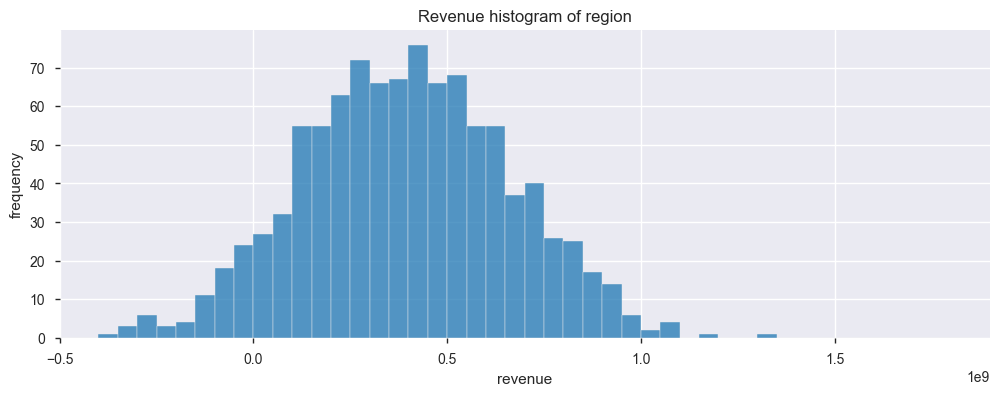


Region 1 :
Средняя прибыль: 462190324.9021857 рублей
Доверительный интервал: от 78050810.8 рублей до 862952060.3 рублей
Вероятность убытков, %: 0.7000000000000001


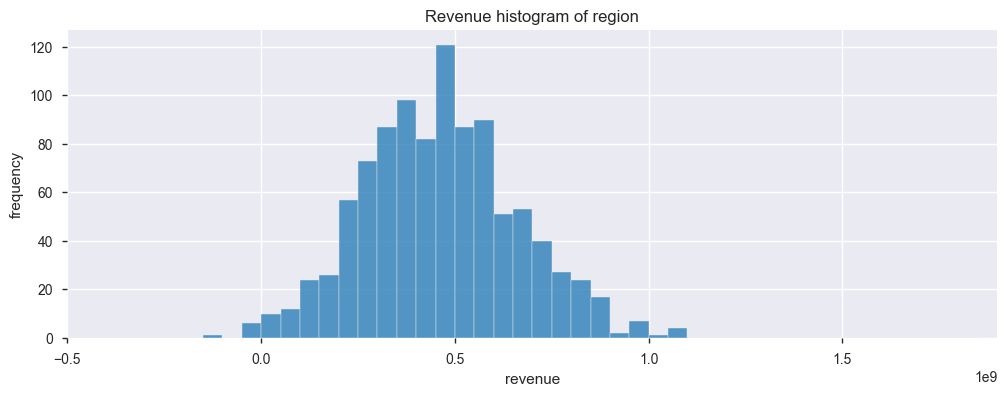


Region 2 :
Средняя прибыль: 392446381.5803062 рублей
Доверительный интервал: от -112227625.4 рублей до 934562914.6 рублей
Вероятность убытков, %: 6.5


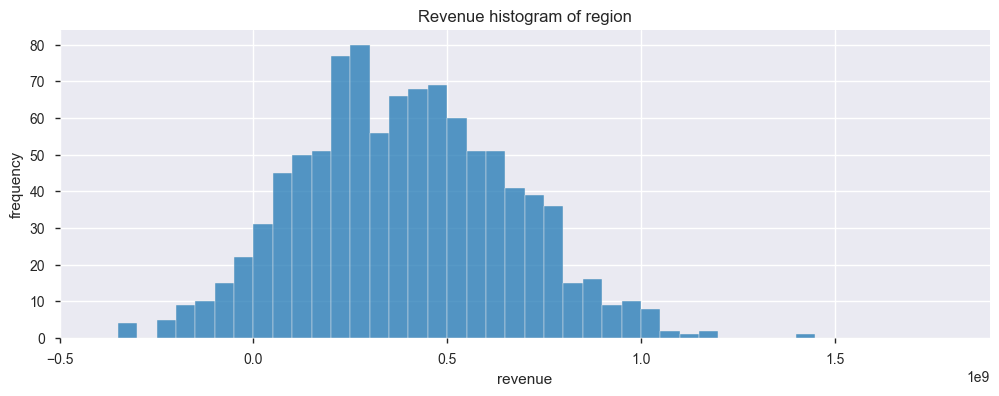

In [37]:
#вывод распределения прибыли по регонам и значений средней прибыли, 
#границ доверительного интервала и вероятности убытков
n = 0
for i in [estimation_of_region_0, estimation_of_region_1, estimation_of_region_2]: 
    print('Region', n, ':')
    estimation_of_region_print(i)
    print()
    n+=1

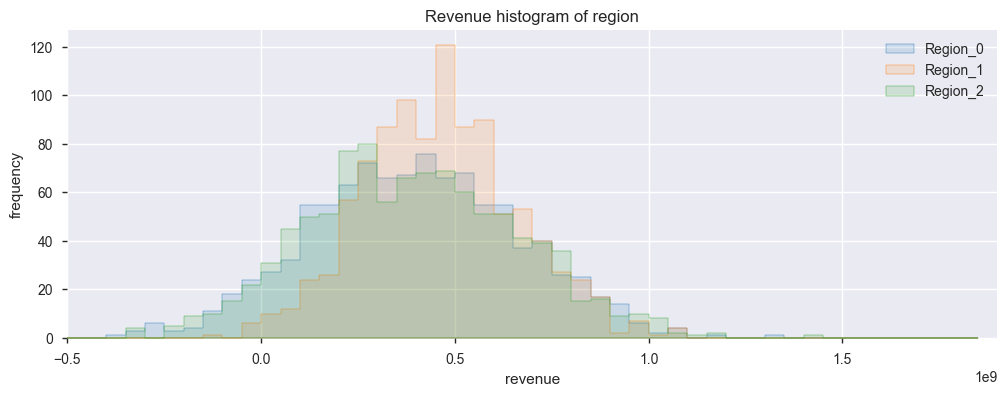

In [38]:
plt.figure(figsize=(12, 4))
sns.histplot(estimation_of_region_0[4], bins=bins, element="step", alpha=0.15, label='Region_0')
sns.histplot(estimation_of_region_1[4], bins=bins, element="step", alpha=0.15, label='Region_1')
sns.histplot(estimation_of_region_2[4], bins=bins, element="step", alpha=0.15, label='Region_2')
plt.title('Revenue histogram of region')
plt.xlabel('revenue')
plt.ylabel('frequency')
plt.xlim([-5*10**8, 1.9*10**9])
plt.legend()
plt.show()

Сведем полученные результаты в таблицу. 

In [39]:
df_results = pd.DataFrame({'region': ['0', '1', '2'],
                   'mean_revenue': [estimation_of_region_0[0], estimation_of_region_1[0], estimation_of_region_2[0]],
                   'conf_interval_lower': [estimation_of_region_0[1], estimation_of_region_1[1], estimation_of_region_2[1]],
                   'conf_interval_upper': [estimation_of_region_0[2], estimation_of_region_1[2], estimation_of_region_2[2]],
                   'prob_of_losses': [estimation_of_region_0[3], estimation_of_region_1[3], estimation_of_region_2[3]]})

In [40]:
df_results

,region,mean_revenue,conf_interval_lower,conf_interval_upper,prob_of_losses
0,0,3.952591e+08,-111215545.9,909766941.6,7.0
1,1,4.621903e+08,78050810.8,862952060.3,0.7
2,2,3.924464e+08,-112227625.4,934562914.6,6.5


### Выводы

Из полученных данных следует:

    1. Наибольшая величина средней прибыли характера для региона 1 (больше на величину до 70 млн. по отношению другим регионам). Средняя величина прибыли для регионов 0 и 2 примерно одинакова.
    2. Самый узкий доверительный интервал в 95% характерен для региона 1, что говорит о том, что при прочих равных условиях, вероятность получить значимую величину прибыли там выше. Далее по увеличению ширины интервала идет регион 2, самый широкий доверительный интервал - у региона 0, при этом значение ширины доверительного интервала для регионов 0 и 2 достаточно близки. Доверительный интервал региона 1 не имеет отрицательных значений - убытков.  
    3. Самый низкий риск убытков характерен для региона 1 (0,7%), далее по возрастанию риска следует регион 2, а самый высокий риск убытков - в регионе 1.

**Таким образом, с учетом наибольшего значения средней прибыли, наимешьшей в абсолютных единицах ширины доверительного интервала и самого низкого риска убытков наиболее предподчтительным для разработки месторождений нефти является регион 1.**

## Общий вывод

Цель исследования: выбор локации - региона и для проведения разработки запасов нефти с учетом максимально возможной прибыли и минимизации риков убытков.

База исследования - три файла с даными о пробах нефти в трёх регионах: информация о качественных параметрах нефти и объёмах её запасов.

В ходе исследования проведено:

1. Ознакомление с данными и их подготовка:
    
   - Каждый файл содержит 10000 строк и 5 столбцов со следующей информацией: 'id' - уникальный идентификатор скважины; 'f0', 'f1', 'f2' - данные о качеcтве и характеристиках нефти; 'product' - объем запасов в скважине в тыс. баррелей.
        
   - В ходе анализа в таблицах найдены дубликаты идентификаторов скважин с отличающимися другими параметрами скважины. Ввиду малого количества подобных дубликатов, строки содержащие их удалены.
        
   - Выделены целевой признак ('product') и признаки ('f0', 'f1', 'f2').
        
   - Данные разделены на тренировочную и валидационную выборки в соотношении 3/1.
        
        
2. Обучение и проверка модели для предсказания объемов запасов в скважине. В качестве модели выбрана линейная регресссия. Найдена среднеквадратичная ошибка моделей предсказания для каждого региона.


3. Для подготовки расчета средней прибыли определены ключевые технико-экономические значения: бюджет разработки скважин в регионе, прибыль с одной тысячи баррелей, колличество исследуемых и подлежащих разработке скважин в регионе, объем сырья в скважине для безубыточной разработки.


4. Проведен подсчет средней прибыли для каждого региона с использованием методики 'bootstrap' 1000 случайных выборок, определено распределение возможной прибыли, подсчитаны границы верхнего и нижего доверительных интервалов распределения прибыли, подсчитана вероятность получения убытка (отрицательной прибыли).


**На основе проведенного анализа средней прибыли, ширины доверительного интервала и вероятности риска убытков установленно, что наиболее перспективным для разработки месторождений нефти является регион 1.**